In [1]:
import os
import tensorflow as tf
import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras import Model
# GPU 설정
os.environ["CUDA_VISIBLE_DEVICES"]="0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
        
tf.debugging.set_log_device_placement(False)
gpus


In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data() # 케라스 mnist 데이터 불러옴
train_images, test_images = train_images / 255.0, test_images / 255.0 # Mnist data 0~1사이 정규화


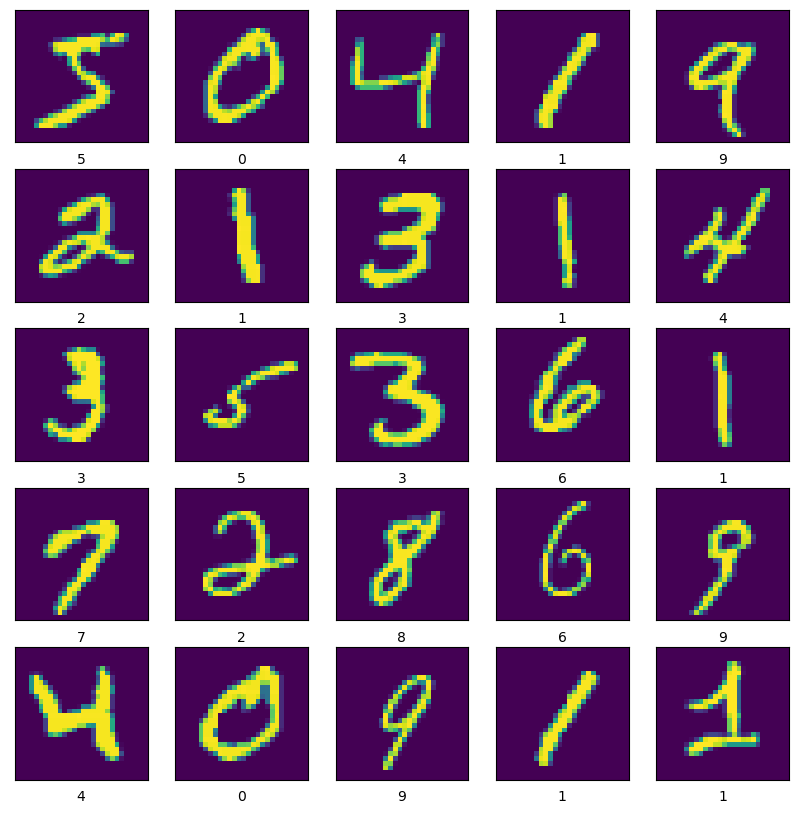

In [4]:

class_names = ['0','1','2','3','4','5','6','7','8','9']

plt.figure(figsize=(10,10))

#데이터 확인

for i in range(25): #이미지 앞에서 25장가져와서
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i]) #데이터와 
    plt.xlabel(class_names[train_labels[i]])# 라벨 출력
plt.show()

In [5]:
#배치,세로,가로,차원 으로 reshape
train_images=train_images.reshape(-1, 28, 28, 1).astype('float64')
test_images=test_images.reshape(-1, 28, 28, 1).astype('float64')

# 데이터의 배치차원(첫번째 차원)을 무시하고 10000개의 버퍼에서 무작위로 뽑은 후 (이미지 라벨)쌍을 배치사이즈로 묶어서 반환
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels)).shuffle(10000).batch(16) 
# 데이터를 순서대로 잘라서 (이미지 라벨)쌍을 배치사이즈로 묶어서 반환
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(16)



In [11]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10))

# model.summary()

# 서브 클래싱 모델 구성
# layer 출력 계산 
#((input-kernel_size)/stride )+ 1
#relu(conv) -> pool 3번 반복 후 fc->fc->out 
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 =layers.Conv2D(32, 3, activation='relu',input_shape=(28,28,1))#out CH =32, k_size =3 ==> (16, 26, 26, 32)
    self.pool1 = layers.MaxPooling2D((2, 2)) # k_size =2 , maxpooling pool1 :  (16, 13, 13, 32)
    self.conv2 = layers.Conv2D(64, (3, 3), activation='relu')#out CH =64,  k_size =3
    self.pool2 = layers.MaxPooling2D((2, 2))
    self.conv3 = layers.Conv2D(128, (3, 3), activation='relu')
    self.pool3 = layers.MaxPooling2D((2, 2))
    self.flatten = layers.Flatten() # FC 층 넘어가기전에 펼쳐준다
    self.fc1 =layers.Dense(128, activation='relu')
    self.fc2 = layers.Dense(10)
    self.show_tensor=[]

  def call(self, x):
    self.show_tensor=[]
    conv1 = self.conv1(x)
    pool1 = self.pool1(conv1)
    conv2 = self.conv2(pool1)
    pool2 = self.pool2(conv2)
    conv3 = self.conv3(pool2)
    pool3 = self.pool3(conv3)
    x = self.flatten(pool3)
    fc1 = self.fc1(x)
    fc2 = self.fc2(fc1)
    out = fc2
    self.show_tensor.extend([conv1,pool1,conv2,pool2,conv3,pool3,fc1,fc2]) #각 계층 출력값 저장
    return out
  
  def show_layer_tensor(self):#텐서 값 출력
    print('conv1 : ',self.show_tensor[0]) 
    print('pool1 : ',self.show_tensor[1])
    print('conv2 : ',self.show_tensor[2])
    print('pool2 : ',self.show_tensor[3])
    print('conv3 : ',self.show_tensor[4])
    print('pool3 : ',self.show_tensor[5])
    print('fc1 : ',self.show_tensor[6])
    print('fc2 : ',self.show_tensor[7])

  def show_layer_tensor_shape(self): # 형태 출력
    print('conv1 : ',self.show_tensor[0].shape) 
    print('pool1 : ',self.show_tensor[1].shape)
    print('conv2 : ',self.show_tensor[2].shape)
    print('pool2 : ',self.show_tensor[3].shape)
    print('conv3 : ',self.show_tensor[4].shape)
    print('pool3 : ',self.show_tensor[5].shape)
    print('fc1 : ',self.show_tensor[6].shape)
    print('fc2 : ',self.show_tensor[7].shape)



model = MyModel()
#  Multi-class classification -> Crossentropy loss 사용
#  CategoricalCrossentropy --> label이 one-hot vector 일때 사용
#  SparseCategoricalCrossentropy --> label이 정수 일때 사용
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer =  tf.keras.optimizers.Adam()



In [7]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#@tf.function
def train_step(images, labels):
  #미분을 위한 GradientTape 사용
  with tf.GradientTape() as tape: 
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  # GradientTape에서 계산된 값들의 gradient를 계산
  gradients = tape.gradient(loss, model.trainable_variables)
  #역전파 
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
  
#@tf.function
def test_step(images, labels):
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [12]:
EPOCHS = 3

for epoch in range(EPOCHS):
  # 에포크를 시작할때 초기화
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  #학습 데이터로 학습진행
  for images, labels in train_ds:
    train_step(images, labels)
  # 테스트 데이터셋으로 테스트
  for images, labels in test_ds:
    test_step(images, labels)

  

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.16845619678497314, Accuracy: 94.66166687011719, Test Loss: 0.06985367089509964, Test Accuracy: 97.97999572753906
Epoch 2, Loss: 0.06432706117630005, Accuracy: 98.04499816894531, Test Loss: 0.06918519735336304, Test Accuracy: 97.77999877929688
Epoch 3, Loss: 0.04499846696853638, Accuracy: 98.61500549316406, Test Loss: 0.04697147756814957, Test Accuracy: 98.54999542236328


In [13]:
model.show_layer_tensor_shape()

conv1 :  (16, 26, 26, 32)
pool1 :  (16, 13, 13, 32)
conv2 :  (16, 11, 11, 64)
pool2 :  (16, 5, 5, 64)
conv3 :  (16, 3, 3, 128)
pool3 :  (16, 1, 1, 128)
fc1 :  (16, 128)
fc2 :  (16, 10)


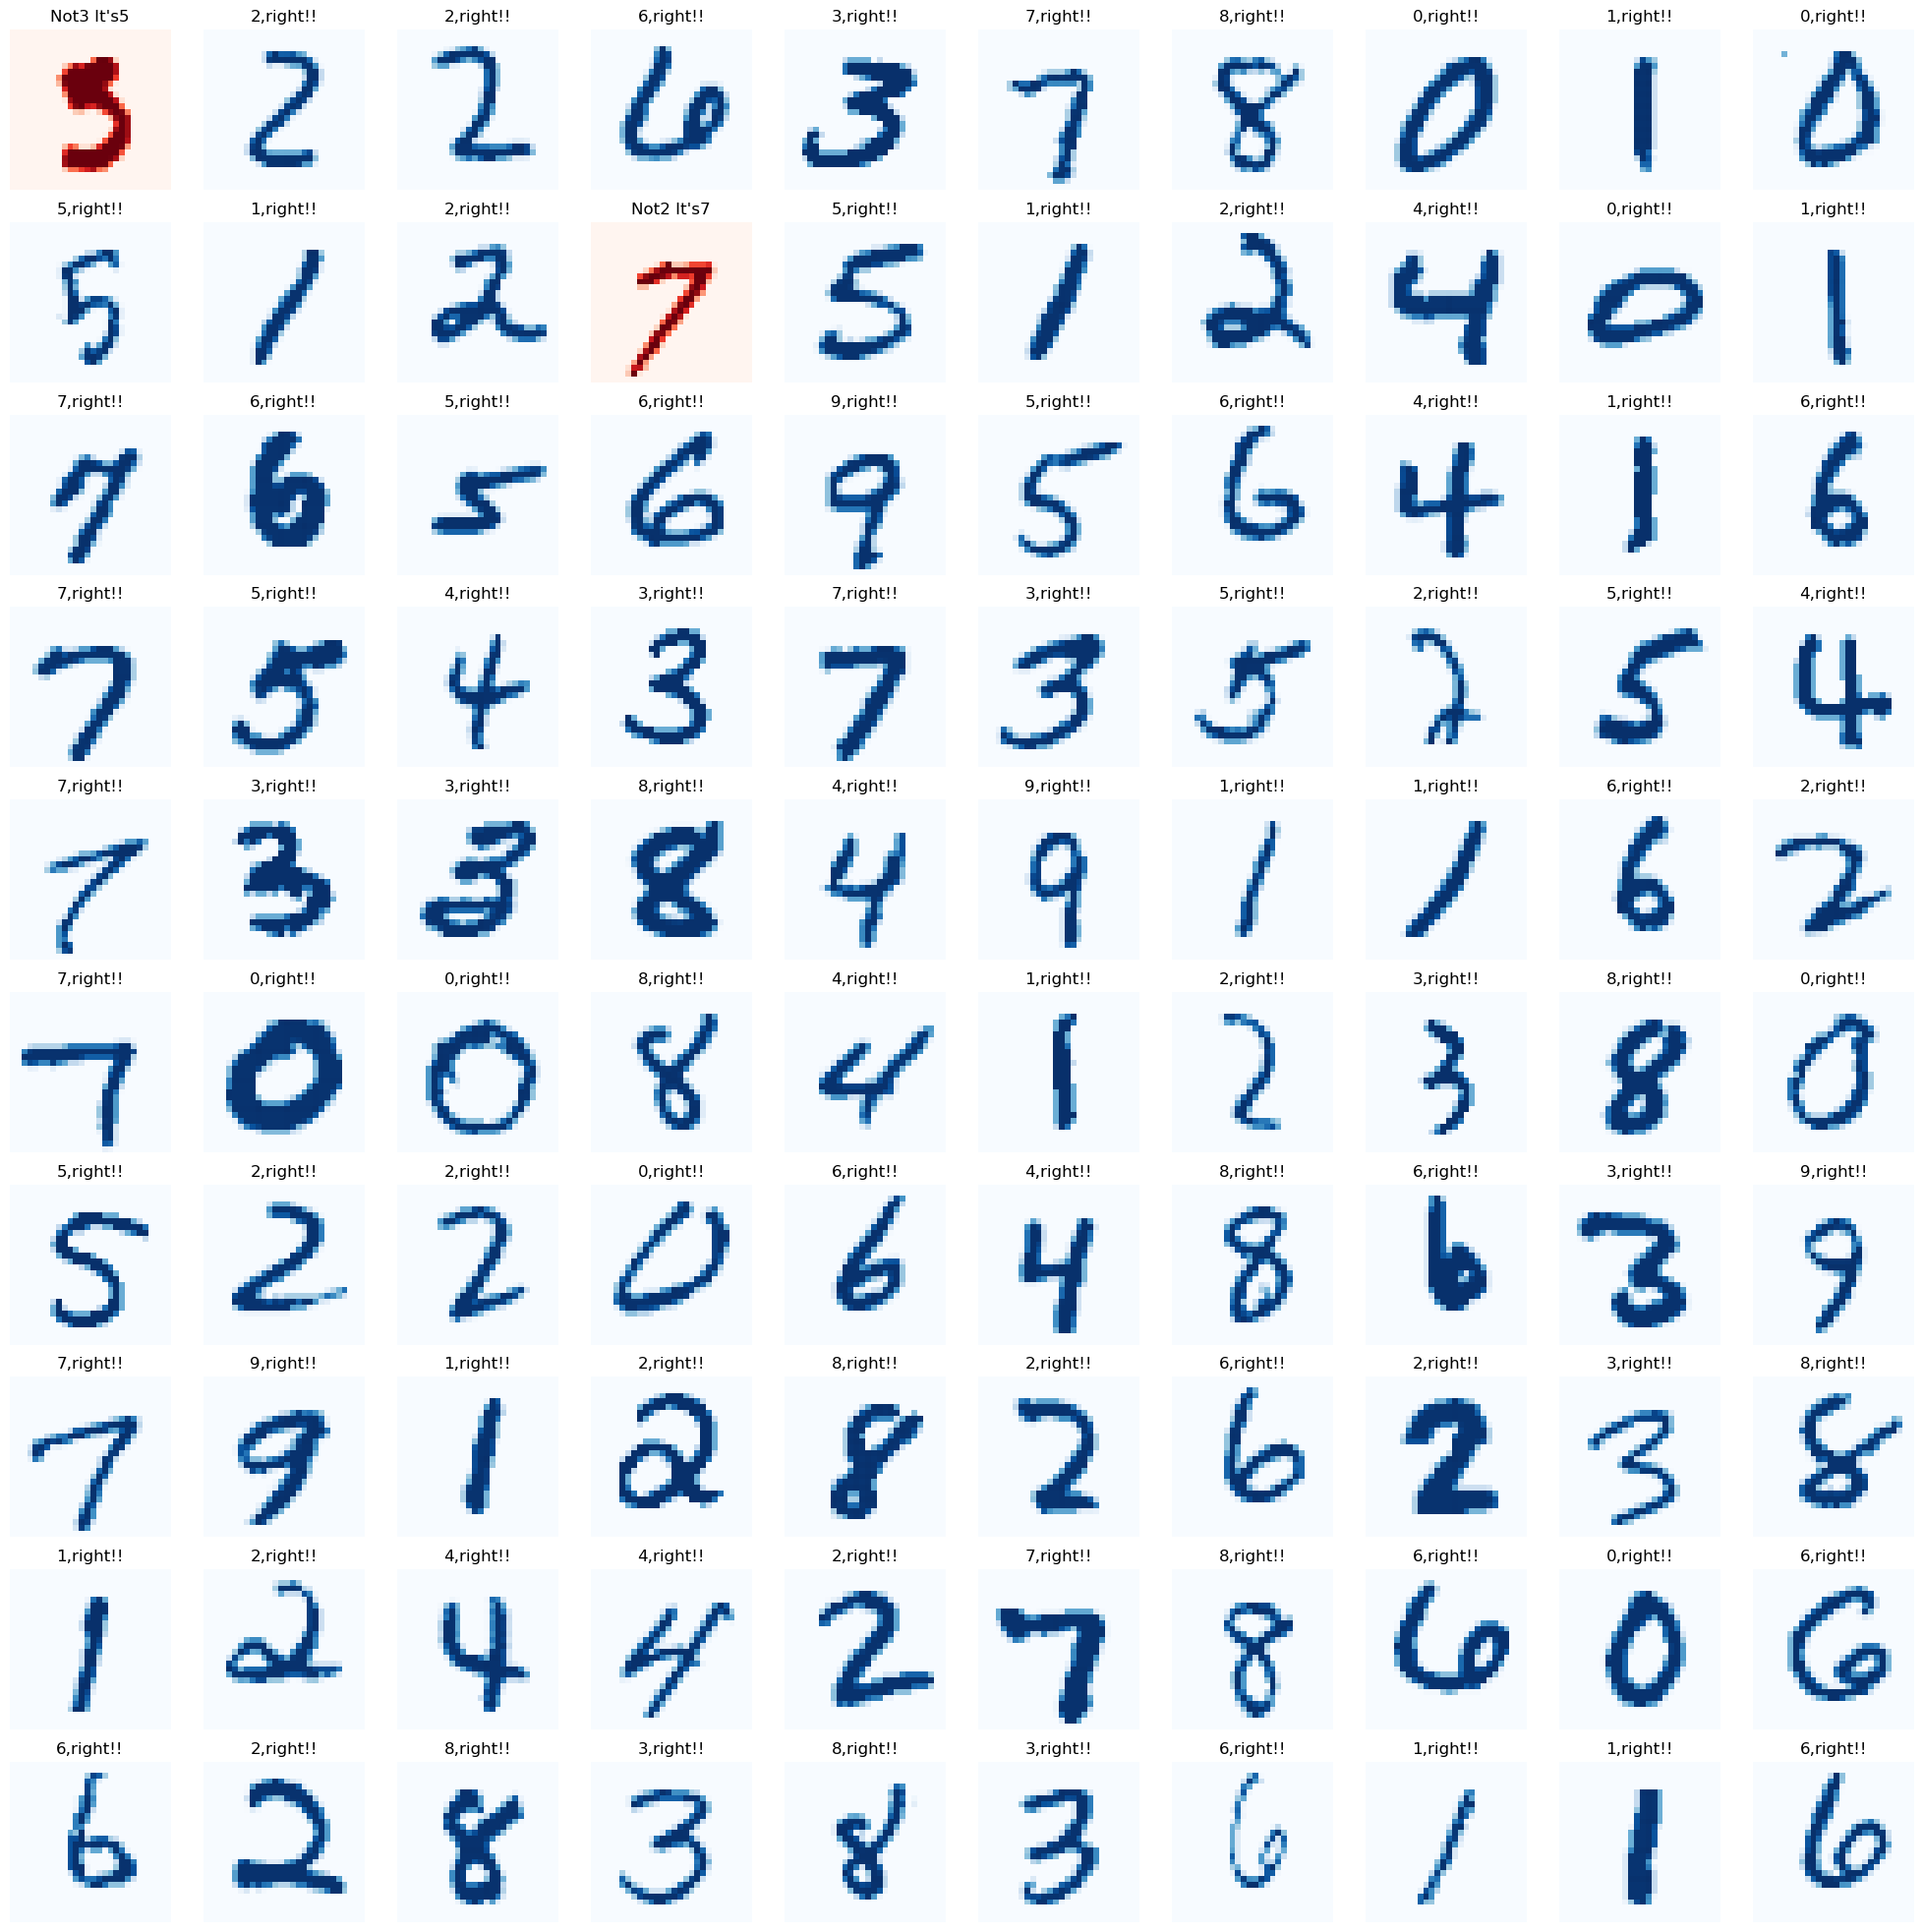

red: 2 blue: 98


In [14]:
import numpy as np
label_dic ={0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9'}
r_cnt=0
b_cnt=0
columns = 10
rows=10
fig = plt.figure(figsize=(25,25))


for i in range(1, columns*rows+1):
  data_idx = np.random.randint(len(test_images)) #테스트 이미지 중 하나를 랜덤하게 선택
  imput_img = tf.expand_dims(test_images[data_idx], axis=0) # 차원수를 맞춰주고
  output=model(imput_img) # 모델에 넣어서 출력값을 받음

  argmax=tf.argmax(output[0],0).numpy() # 모델의 출력이 (1,10) 형태이므로 가장큰 값의 인덱스를 가져온다

  pred=label_dic[argmax] # 모델의 출력값을 라벨에 매칭하고 


  label=label_dic[test_labels[data_idx]] # 실제 라벨값을 가져온다

  fig.add_subplot(rows,columns,i)
  if pred==label: # 모델의 출력값과 실제 라벨이 같으면
    plt.title(pred+',right!!')
    cmap='Blues' #파란색으로 
    b_cnt+=1
  else: # 모델의 출력과 실제 라벨이 다르면
    plt.title('Not'+pred+' '+'It\'''s'+label)
    cmap='Reds' #빨간색으로
    r_cnt+=1
  plot_img=test_images[data_idx] 
  plt.imshow(plot_img,cmap=cmap) #이미지를 출력한다
  plt.axis('off')

plt.show()
print("red:",r_cnt,"blue:",b_cnt) #빨강과 파랑의 개수를 반환한다